In [1]:
import tensorflow as tf
import modules.tf_util as tf_util
import numpy as np
import tables
import matplotlib.pyplot as plt

#######################################################
# Get data
#######################################################
data_path = '/media/marsdenlab/Data1/datasets/DeepVessel/'
train = data_path+'train_dist72_white_large_ct.hdf5'
val = data_path+'val_dist72_white_large_ct.hdf5'
test = data_path+'test_dist72_white_ct.hdf5'

neg_train = data_path+'train_dist72_white_negative_ct.hdf5'
neg_val = data_path+'val_dist72_white_negative_ct.hdf5'
f_train = tables.open_file(train)
f_val = tables.open_file(val)

f_neg_train = tables.open_file(neg_train)
f_neg_val = tables.open_file(neg_val)

input_shape = f_train.root.X.shape
output_shape = f_train.root.Y.shape
print input_shape, output_shape

print 'data shapes, train={},{}'.format(input_shape,output_shape)


input_shape = f_neg_train.root.X.shape
output_shape = f_neg_train.root.Y.shape
print input_shape, output_shape

print 'data shapes, train={},{}'.format(input_shape,output_shape)

(592894, 72, 72, 72) (592894, 72, 72, 72, 3)
data shapes, train=(592894, 72, 72, 72),(592894, 72, 72, 72, 3)
(160000, 72, 72, 72) (160000, 72, 72, 72, 3)
data shapes, train=(160000, 72, 72, 72),(160000, 72, 72, 72, 3)


In [2]:
######################################################
# Define variables
######################################################
N = f_train.root.X.shape[0]
N_neg = f_neg_train.root.X.shape[0]
Nval = f_val.root.X.shape[0]
W,H,D = f_train.root.X[0].shape
C = 1
Nbatch = 4
lr = 1e-5
Nsteps=100000
print_step=1000
init = 1.0e-3
Nlayers = 8
Nfilters = 32
VESSEL_SCALE = 1000
EPS=1e-4
leaky_relu = tf.contrib.keras.layers.LeakyReLU(0.2)
y_index=0
alph = 0.3
beta = 0.7

In [3]:


def selu(x):
    with ops.name_scope('elu') as scope:
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
    return scale*tf.where(x>=0.0, x, alpha*tf.nn.elu(x)-alpha)
#########################################################
# Define graph
#########################################################
x = tf.placeholder(shape=[None,W,H,D,C],dtype=tf.float32)
y = tf.placeholder(shape=[None,W,H,D,C],dtype=tf.float32)

# o_4 = tf_util.conv3D_N(x,N=Nlayers,nfilters=Nfilters,init=init,activation=leaky_relu)

# yhat = tf_util.conv3D(o_4,tf.identity,nfilters=1,scope='yhat',init=init)
# yclass = tf.sigmoid(yhat)

yhat,yclass = tf_util.UNET3D(x,nfilters=Nfilters,activation=leaky_relu,init=init)

#loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y,logits=yhat,name='loss'))

TP = tf.reduce_sum(yclass*y)
FP = tf.reduce_sum(yclass*(1-y))
FN = tf.reduce_sum((1-yclass)*y)
loss = -TP/(TP + alph*FP+beta*FN+EPS)
# loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(targets=y,logits=yhat,
#     pos_weight=VESSEL_SCALE,name='loss'))

# loss = tf.reduce_mean(-(1.0-y)*tf.log(1.0-yclass+EPS) - VESSEL_SCALE*y*tf.log(yclass+EPS))
opt = tf.train.AdamOptimizer(lr)
train = opt.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

print yhat

Tensor("layer1/conv3d_1/leaky_re_lu_1/sub:0", shape=(?, 72, 72, 72, 64), dtype=float32) Tensor("layer1/pool:0", shape=(?, 36, 36, 36, 64), dtype=float32)
Tensor("layer2/conv3d_1/leaky_re_lu_1/sub:0", shape=(?, 36, 36, 36, 128), dtype=float32) Tensor("layer2/pool:0", shape=(?, 18, 18, 18, 128), dtype=float32)
Tensor("layer3/conv3d_1/leaky_re_lu_1/sub:0", shape=(?, 18, 18, 18, 256), dtype=float32) Tensor("layer3/pool:0", shape=(?, 9, 9, 9, 256), dtype=float32)
Tensor("layer4/conv3d_1/leaky_re_lu_1/sub:0", shape=(?, 9, 9, 9, 512), dtype=float32) Tensor("layer4/pool:0", shape=(?, 5, 5, 5, 512), dtype=float32)
Tensor("o_layer3/conv3d_1/leaky_re_lu_1/sub:0", shape=(?, 18, 18, 18, 256), dtype=float32)
Tensor("o_layer2/conv3d_1/leaky_re_lu_1/sub:0", shape=(?, 36, 36, 36, 128), dtype=float32)
Tensor("o_layer1/conv3d_1/leaky_re_lu_1/sub:0", shape=(?, 72, 72, 72, 64), dtype=float32)
Tensor("yhat/Identity:0", shape=(?, 72, 72, 72, 1), dtype=float32)
Tensor("Sigmoid:0", shape=(?, 72, 72, 72, 1), dt

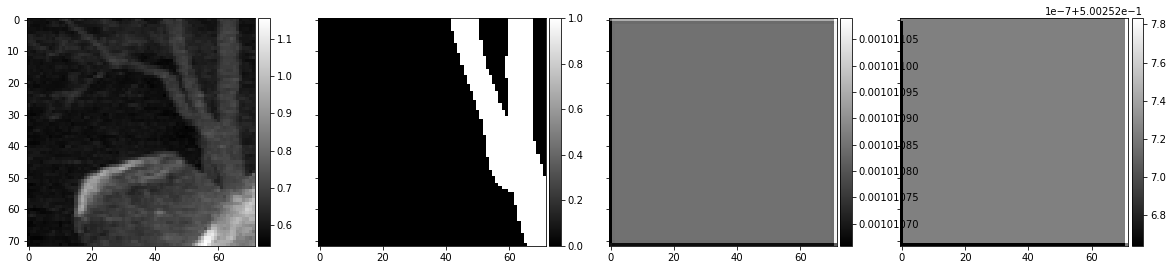

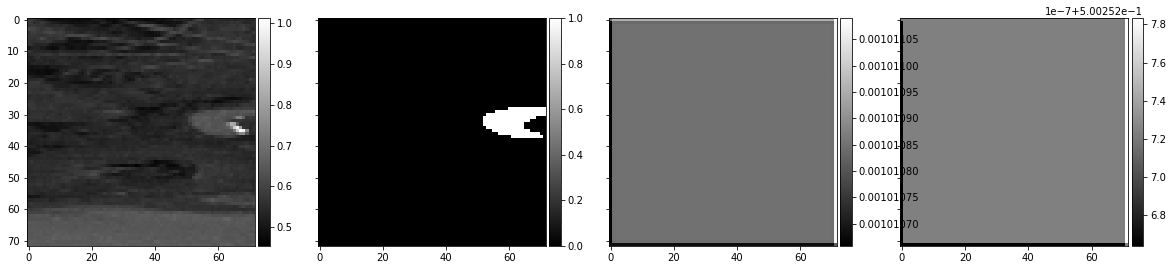

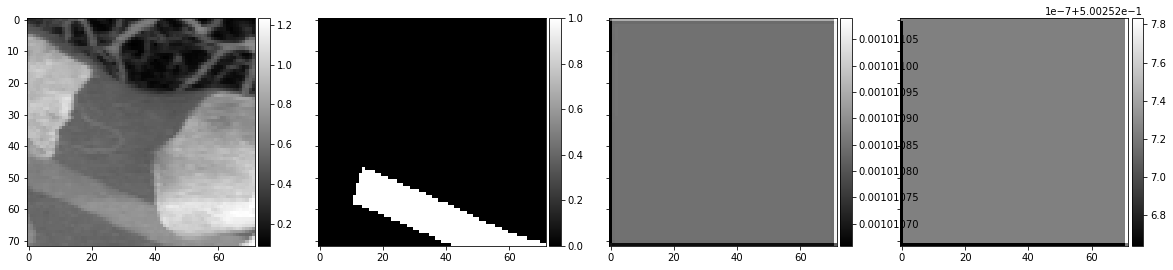

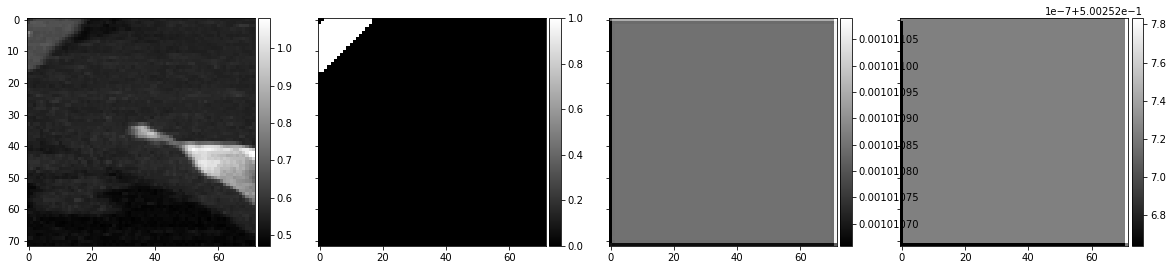

IndexError: index 0 is out of bounds for axis 0 with size 0

In [4]:
######################################################
# Plot
######################################################
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['figure.figsize'] = (20.0, 10.0)
def implot(mp,ax):
    im = ax.imshow(mp.astype(np.float32), cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    
xb,yb = tf_util.get_batch(f_train.root.X,f_train.root.Y,N,n=Nbatch,y_index=y_index)
out,yout =sess.run([yhat,yclass],{x:xb,y:yb})

for i in range(5):
    xval = xb[i:i+2]
    yval = yb[i:i+2][:,:,:,:]
    ypred = yout[i:i+2]
    out_pred = out[i:i+2]
    mpx = np.amax(xval[0,:,:,:,0],axis=(1))
    mpy = np.amax(yval[0,:,:,:,0],axis=(1))
    mpo = np.amax(out_pred[0,:,:,:,0],axis=(1))
    mpd = np.amax(ypred[0,:,:,:,0],axis=(1))
    
    plt.figure()
    fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, sharey=True)
    implot(mpx,ax1)
    implot(mpy,ax2)
    implot(mpo,ax3)
    implot(mpd,ax4)
    plt.tight_layout
    plt.show()
    
for i in range(5):
    xval = xb[i:i+2]
    yval = yb[i:i+2][:,:,:,:]
    ypred = yout[i:i+2]
    out_pred = out[i:i+2]
    
    plt.figure()
    fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, sharey=True)
    implot(xval[0,32,:,:,0],ax1)
    implot(yval[0,32,:,:,0],ax2)
    implot(out_pred[0,32,:,:,0],ax3)
    implot(ypred[0,32,:,:,0],ax4)
    plt.tight_layout
    plt.show()

In [5]:
print xval.shape
print yval.shape
print out.shape
print yout.shape

(0, 72, 72, 72, 1)
(0, 72, 72, 72, 1)
(4, 72, 72, 72, 1)
(4, 72, 72, 72, 1)


In [ ]:
#######################################################
# Train positive
#######################################################
train_hist = []
val_hist = []

for i in range(Nsteps+1):
    xb,yb = tf_util.get_batch(f_train.root.X,f_train.root.Y,N,n=Nbatch,y_index=y_index)
    l,_=sess.run([loss,train],{x:xb,y:yb})
    if i%(print_step/5)==0:
        print "iteration {}".format(i)
    if i%(print_step/5) == 0:
        xb,yb = tf_util.get_batch(f_val.root.X,f_val.root.Y,Nval,Nbatch,y_index=y_index)
        lval,ypred=sess.run([loss,yclass],{x:xb,y:yb})
        print "Train: {}, Val: {}, p var {}, p mean {}, p max {}, p min {}".format(l,lval,
                np.var(ypred),np.mean(ypred), np.amax(ypred),np.amin(ypred))



In [ ]:
#######################################################
# Train
#######################################################
train_hist = []
val_hist = []

for i in range(Nsteps+1):
    xb,yb = tf_util.get_batch(f_train.root.X,f_train.root.Y,N,n=3*Nbatch/4,y_index=y_index)
    xbn,ybn = tf_util.get_batch(f_neg_train.root.X,f_neg_train.root.Y,N_neg,n=Nbatch/2,y_index=y_index)
    xb = np.concatenate((xb,xbn),axis=0)
    yb = np.concatenate((yb,ybn),axis=0)
    l,_=sess.run([loss,train],{x:xb,y:yb})
    if i%(print_step/5)==0:
        print "iteration {}".format(i)
    if i%(print_step/5) == 0:
        xb,yb = tf_util.get_batch(f_val.root.X,f_val.root.Y,Nval,Nbatch,y_index=1)
        lval,ypred=sess.run([loss,yclass],{x:xb,y:yb})
        print "Train: {}, Val: {}, p var {}, p mean {}, p max {}, p min {}".format(l,lval,
                np.var(ypred),np.mean(ypred), np.amax(ypred),np.amin(ypred))
        
        train_hist.append(l)
        val_hist.append(lval)

iteration 0
Train: -0.253089100122, Val: -0.57285040617, p var 1.27557231271e-12, p mean 0.500256597996, p max 0.500255584717, p min 0.500255465508


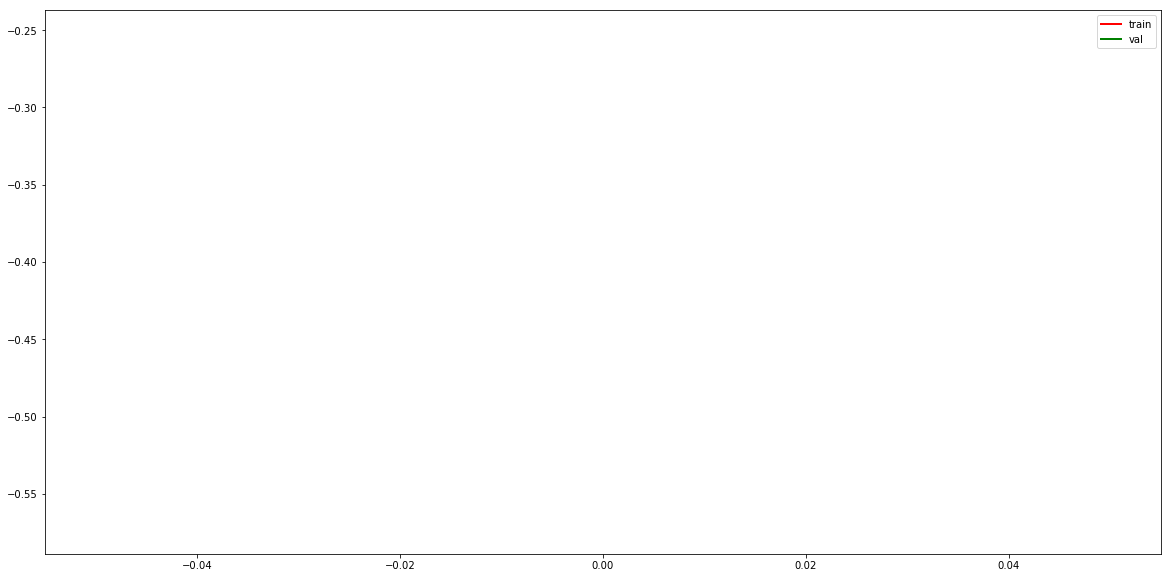

In [7]:
plt.figure()
plt.plot(train_hist, linewidth=2,color='r',label='train')
plt.plot(val_hist, linewidth=2,color='g',label='val')
plt.legend()
plt.show()

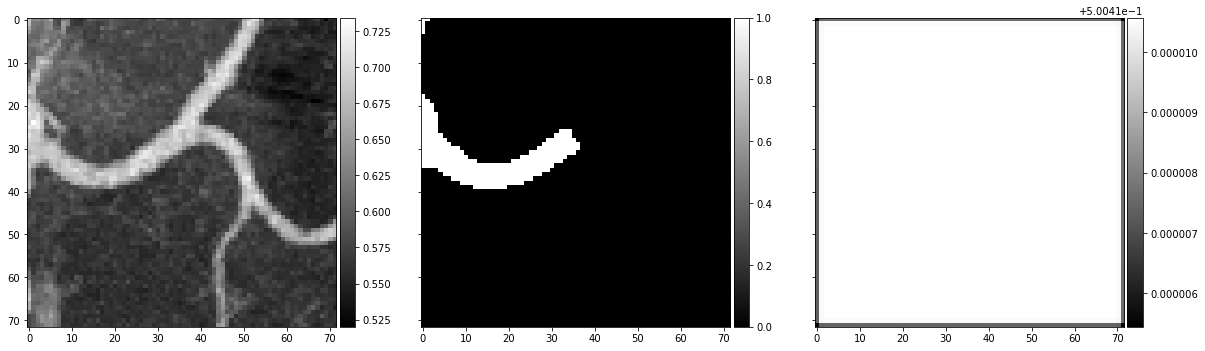

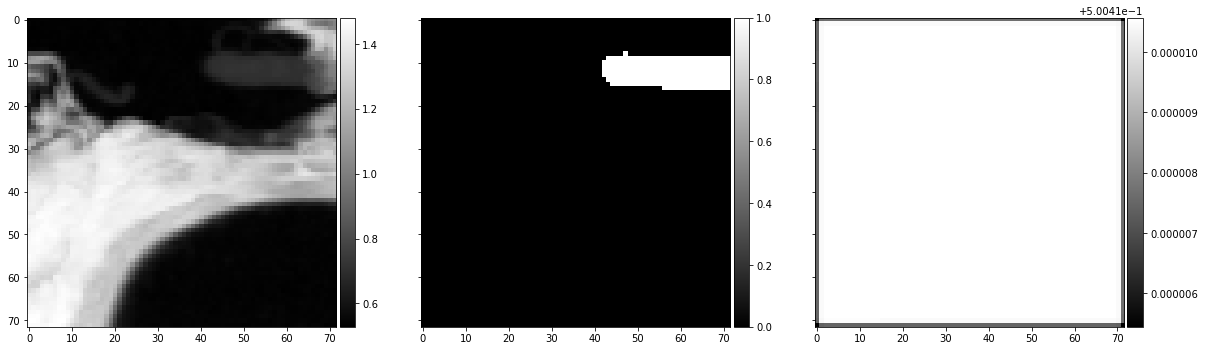

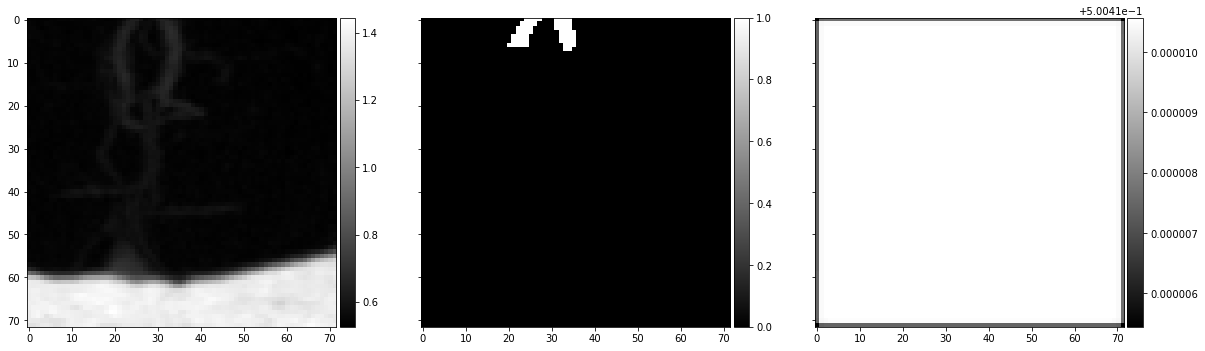

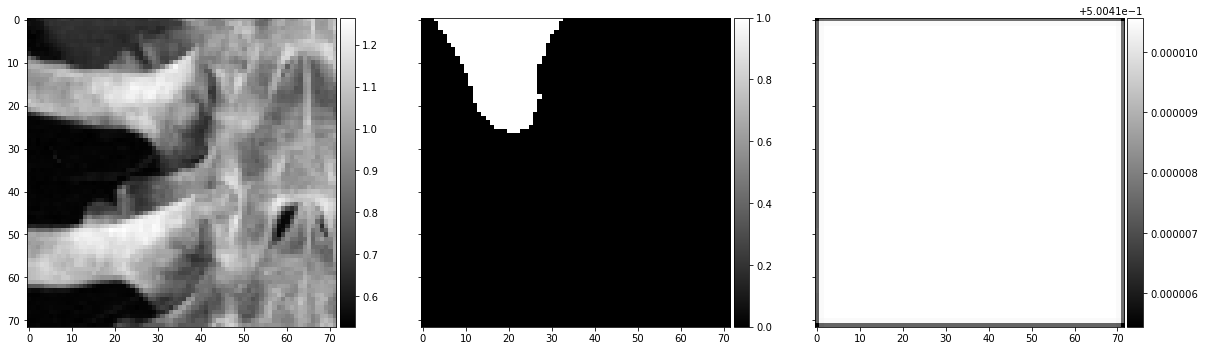

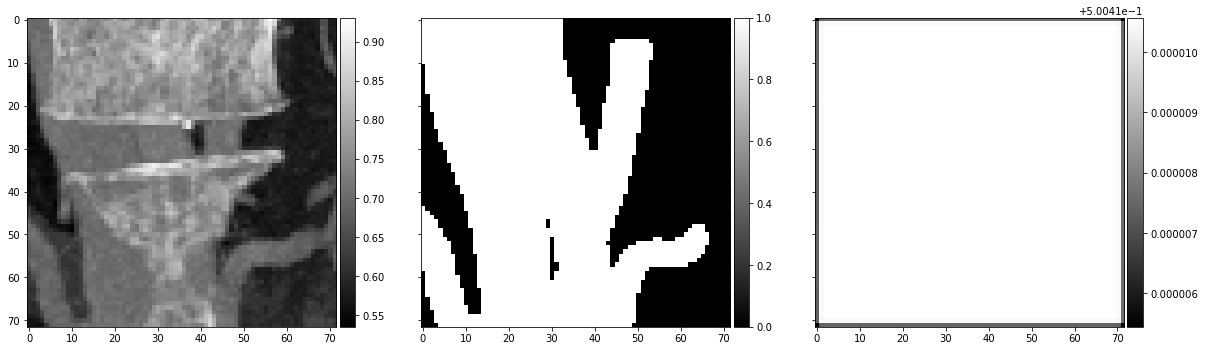

In [8]:


for i in range(5):
    j = np.random.randint(len(f_val.root.X))
    xval = f_val.root.X[j:j+2][:,:,:,:,np.newaxis]
    yval = f_val.root.Y[j:j+2][:,:,:,:,0]
    yval = yval[:,:,:,:,np.newaxis]
    ypred = sess.run(yclass,{x:xval,y:yval})
    mpx = np.amax(xval[0,:,:,:,0],axis=(1))
    mpy = np.amax(yval[0,:,:,:,0],axis=(1))
    mpd = np.amax(ypred[0,:,:,:,0],axis=(1))

    plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    implot(mpx,ax1)
    implot(mpy,ax2)
    implot(mpd,ax3)
    plt.tight_layout
    plt.show()

In [ ]:
saver = tf.train.Saver()
saver.save(sess,'./models/unet/unet')

INFO:tensorflow:Restoring parameters from ./models/unet/unet


INFO:tensorflow:Restoring parameters from ./models/unet/unet


In [4]:
saver = tf.train.Saver()
saver.restore(sess,'./models/unet/unet')

INFO:tensorflow:Restoring parameters from ./models/unet/unet
